In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from time import time

import keras
from keras import layers
from keras.optimizers import RMSprop
from tensorflow import data as tf_data
import tensorflow_datasets as tfds


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d yuvrajsinhachowdhury/herlev-dataset

Dataset URL: https://www.kaggle.com/datasets/yuvrajsinhachowdhury/herlev-dataset
License(s): unknown
herlev-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile

with ZipFile('/content/herlev-dataset.zip','r') as zip:
  zip.extractall('/content')

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
#from keras import ops
from keras import layers
import tensorflow as tf

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np


In [ ]:
INP_SIZE = (256,256)
TARGET_SIZE = (150,150)
INTERPOLATION = "bilinear"

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 5

In [ ]:
X_train = []
y_train = []
image_size = 150
labels = ['carcinoma_in_situ','light_dysplastic','moderate_dysplastic','normal_columnar','normal_intermediate','normal_superficiel','severe_dysplastic']
for i in labels:
    folderPath = os.path.join('/content/Herlev Dataset/train',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Herlev Dataset/test',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)


In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/Herlev Dataset/train',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/Herlev Dataset/train',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)


In [ ]:
len(y_train)

917

In [ ]:
classes=['carcinoma_in_situ','light_dysplastic','moderate_dysplastic','normal_columnar','normal_intermediate','normal_superficiel','severe_dysplastic']

In [ ]:
X_train,y_train=shuffle(X_train,y_train,random_state=1)
X_train.shape

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
images_dict = dict()
x_train_dict=dict()
for i, l in enumerate(y_train_new):
  if len(images_dict)==7:
    break
  if l not in images_dict.keys():
    x_train_dict[l] = X_train[i]
    images_dict[l] = X_train[i].reshape((150,150,3))
images_dict = dict(sorted(images_dict.items()))
x_trian_each_class = [x_train_dict[i] for i in sorted(x_train_dict)]
x_train_each_class = np.asarray(x_trian_each_class)

X_test_dict = dict()
for i, l in enumerate(y_test_new):
  if len(X_test_dict)==7:
    break
  if l not in X_test_dict.keys():
    X_test_dict[l] = X_test[i]
# order by class
x_test_each_class = [X_test_dict[i] for i in sorted(X_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

In [ ]:
from tensorflow.keras.optimizers import RMSprop
class GCRMSprop(RMSprop):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= ops.mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads


optimizer = GCRMSprop(learning_rate=1e-4)

In [ ]:
# Import the keras module
import keras
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.epoch_time_start)


In [ ]:
def conv_block(x, filters, kernel_size, strides, activation=layers.LeakyReLU(0.2)):
    x = layers.Conv2D(filters, kernel_size, strides, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = activation(x)
    return x


def res_block(x):
    inputs = x
    x = conv_block(x, 16, 3, 1)
    x = conv_block(x, 16, 3, 1, activation=None)
    return layers.Add()([inputs, x])

    # Note: user can change num_res_blocks to >1 also if needed


def get_learnable_resizer(filters=16, num_res_blocks=1, interpolation=INTERPOLATION):
    inputs = layers.Input(shape=[None, None, 3])

    # First, perform naive resizing.
    naive_resize = layers.Resizing(*TARGET_SIZE, interpolation=interpolation)(inputs)

    # First convolution block without batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=7, strides=1, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)

    # Second convolution block with batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    # Intermediate resizing as a bottleneck.
    bottleneck = layers.Resizing(*TARGET_SIZE, interpolation=interpolation)(x)

    # Residual passes.
    # First res_block will get bottleneck output as input
    x = res_block(bottleneck)
    # Remaining res_blocks will get previous res_block output as input
    for _ in range(num_res_blocks - 1):
        x = res_block(x)

    # Projection.
    x = layers.Conv2D(
        filters=filters, kernel_size=3, strides=1, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)

    # Skip connection.
    x = layers.Add()([bottleneck, x])

    # Final resized image.
    x = layers.Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
    final_resize = layers.Add()([naive_resize, x])

    return keras.Model(inputs, final_resize, name="learnable_resizer")


learnable_resizer = get_learnable_resizer()


In [ ]:
effnet = tf.keras.applications.EfficientNetV2L(weights='imagenet',include_top=False,input_shape=(150,150,3))

473176280/473176280 [==============================] - 2s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(7,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
def conv_block(x, filters, kernel_size, strides, activation=layers.LeakyReLU(0.2)):
    x = layers.Conv2D(filters, kernel_size, strides, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = activation(x)
    return x


def res_block(x):
    inputs = x
    x = conv_block(x, 16, 3, 1)
    x = conv_block(x, 16, 3, 1, activation=None)
    return layers.Add()([inputs, x])

    # Note: user can change num_res_blocks to >1 also if needed


def get_learnable_resizer(filters=16, num_res_blocks=1, interpolation=INTERPOLATION):
    inputs = layers.Input(shape=[None, None, 3])

    # First, perform naive resizing.
    naive_resize = layers.Resizing(*TARGET_SIZE, interpolation=interpolation)(inputs)

    # First convolution block without batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=7, strides=1, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)

    # Second convolution block with batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    # Intermediate resizing as a bottleneck.
    bottleneck = layers.Resizing(*TARGET_SIZE, interpolation=interpolation)(x)

    # Residual passes.
    # First res_block will get bottleneck output as input
    x = res_block(bottleneck)
    # Remaining res_blocks will get previous res_block output as input
    for _ in range(num_res_blocks - 1):
        x = res_block(x)

    # Projection.
    x = layers.Conv2D(
        filters=filters, kernel_size=3, strides=1, padding="same", use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)

    # Skip connection.
    x = layers.Add()([bottleneck, x])

    # Final resized image.
    x = layers.Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
    final_resize = layers.Add()([naive_resize, x])

    return keras.Model(inputs, final_resize, name="learnable_resizer")


learnable_resizer = get_learnable_resizer()


In [ ]:
checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

In [ ]:
def get_model():
    inputs = layers.Input((INP_SIZE[0], INP_SIZE[1], 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    x = learnable_resizer(x)
    outputs = model(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
model = get_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 learnable_resizer (Functio  (None, 150, 150, 3)       12163     
 nal)                                                            
                                                                 
 model (Functional)          (None, 7)                 117755815 
                                                                 
Total params: 117767978 (449.25 MB)
Trainable params: 117255274 (447.29 MB)
Non-trainable params: 512704 (1.96 MB)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
time_callback_no_gc = TimeHistory()
model.compile(loss='categorical_crossentropy',optimizer =optimizer, metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)

In [ ]:
history=model.fit( X_train, y_train,validation_data = (X_test, y_test), epochs =30,verbose=1, batch_size=8,
                   callbacks=[tensorboard,checkpoint,reduce_lr,time_callback_no_gc])
history = pd.DataFrame(history.history)

Epoch 1/30
  6/104 [>.............................] - ETA: 26s - loss: 1.8902 - accuracy: 0.2292

104/104 [==============================] - ETA: 0s - loss: 1.4420 - accuracy: 0.4388
Epoch 1: val_accuracy improved from -inf to 0.23913, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 186s 426ms/step - loss: 1.4420 - accuracy: 0.4388 - val_loss: 1.9065 - val_accuracy: 0.2391 - lr: 1.0000e-04
Epoch 2/30
104/104 [==============================] - ETA: 0s - loss: 1.0895 - accuracy: 0.5818
Epoch 2: val_accuracy improved from 0.23913 to 0.31522, saving model to effnet.h5
104/104 [==============================] - 40s 381ms/step - loss: 1.0895 - accuracy: 0.5818 - val_loss: 1.9854 - val_accuracy: 0.3152 - lr: 1.0000e-04
Epoch 3/30
104/104 [==============================] - ETA: 0s - loss: 0.8649 - accuracy: 0.6545
Epoch 3: val_accuracy did not improve from 0.31522
104/104 [==============================] - 29s 276ms/step - loss: 0.8649 - accuracy: 0.6545 - val_loss: 1.8812 - val_accuracy: 0.2283 - lr: 1.0000e-04
Epoch 4/30
104/104 [==============================] - ETA: 0s - loss: 0.7734 - accuracy: 0.7115
Epoch 4: val_accuracy improved from 0.31522 to 0.40217, saving model to effnet.h5
104/104 [==============================] - 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,Concatenate, AveragePooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def dense_block(x, blocks, growth_rate):
    for _ in range(blocks):
        x = conv_block(x, growth_rate)
    return x

def transition_block(x, reduction):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[3] * reduction), (1, 1), padding='same')(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

def conv_block(x, growth_rate):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(4 * growth_rate, (1, 1), padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same')(x1)
    x = Concatenate(axis=-1)([x, x1])
    return x

def densenet121(input_shape=None, classes=10):
    input_shape = input_shape or (150, 150, 3)
    img_input = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = dense_block(x, 6, 32)
    x = transition_block(x, 0.5)
    x = dense_block(x, 12, 32)
    x = transition_block(x, 0.5)
    x = dense_block(x, 16, 32)
    x = transition_block(x, 0.5)
    x = dense_block(x, 8, 32)

    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(img_input, x, name='densenet121')
    return model

# Create the DenseNet-121 model
model = densenet121()

# Print model summary

#model.summary()


In [ ]:
history=model.fit( X_train, y_train,validation_data = (X_test, y_test), epochs =20,verbose=1, batch_size=8,
                   callbacks=[tensorboard,checkpoint,reduce_lr,time_callback_no_gc])
history = pd.DataFrame(history.history)

Epoch 1/20
104/104 [==============================] - ETA: 0s - loss: 1.6791 - accuracy: 0.3321
Epoch 1: val_accuracy improved from -inf to 0.20652, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 424s 4s/step - loss: 1.6791 - accuracy: 0.3321 - val_loss: 2.0224 - val_accuracy: 0.2065 - lr: 1.0000e-04
Epoch 2/20
104/104 [==============================] - ETA: 0s - loss: 1.4696 - accuracy: 0.4097
Epoch 2: val_accuracy improved from 0.20652 to 0.27174, saving model to effnet.h5
104/104 [==============================] - 399s 4s/step - loss: 1.4696 - accuracy: 0.4097 - val_loss: 2.1249 - val_accuracy: 0.2717 - lr: 1.0000e-04
Epoch 3/20
104/104 [==============================] - ETA: 0s - loss: 1.4031 - accuracy: 0.4303
Epoch 3: val_accuracy did not improve from 0.27174
104/104 [==============================] - 375s 4s/step - loss: 1.4031 - accuracy: 0.4303 - val_loss: 2.4373 - val_accuracy: 0.2065 - lr: 1.0000e-04
Epoch 4/20
104/104 [==============================] - ETA: 0s - loss: 1.2873 - accuracy: 0.4945
Epoch 4: val_accuracy did not improve from 0.27174

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
104

In [ ]:
def plot_sample(x,y,index):
  plt.figure(figsize=(15,2))
  plt.imshow(x[index])
  plt.xlabel(classes[y[index]])

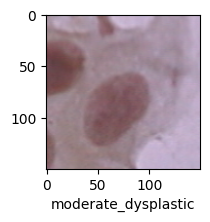

In [ ]:

plot_sample(X_train,y_train_new,0)

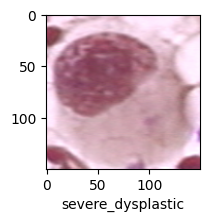

In [ ]:
plot_sample(X_train,y_train_new,6)

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.epoch_time_start)


# **EfficientNetV2L**

In [ ]:
effnet = tf.keras.applications.EfficientNetV2L(weights='imagenet',include_top=False,input_shape=(150,150,3))

473176280/473176280 [==============================] - 21s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(7,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
time_callback_gc = TimeHistory()
model.compile(loss='categorical_crossentropy',optimizer =optimizer, metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("EVf.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
history = model.fit(X_train,y_train,validation_data=(X_test, y_test), epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 1.4386 - accuracy: 0.4606
Epoch 1: val_accuracy improved from -inf to 0.58696, saving model to EVf.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 159s 1s/step - loss: 1.4386 - accuracy: 0.4606 - val_loss: 1.0684 - val_accuracy: 0.5870 - lr: 1.0000e-04
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.7237 - accuracy: 0.7758
Epoch 2: val_accuracy improved from 0.58696 to 0.66304, saving model to EVf.h5
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.9152
Epoch 3: val_accuracy did not improve from 0.66304
26/26 [==============================] - 21s 802ms/step - loss: 0.3267 - accuracy: 0.9152 - val_loss: 0.9385 - val_accuracy: 0.6087 - lr: 1.0000e-04
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.9600
Epoch 4: val_accuracy did not improve from 0.66304

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
26/26 [==============================] - 21s 799ms/step - loss: 0.1539 - accuracy: 0.9600 - val_loss: 0.8739 - val_accuracy: 0.6630 - lr: 1.0000e-04
Epoch 5/50
26/

predict

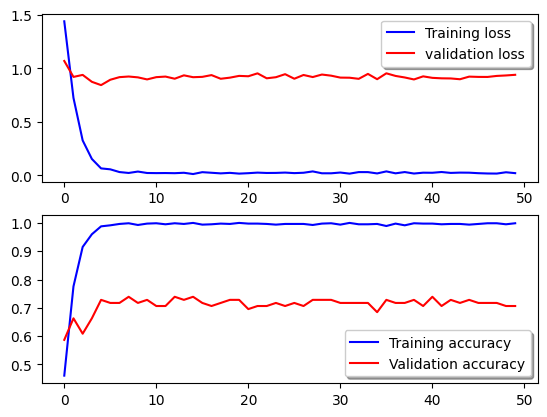

In [ ]:
# prompt: make test and train accurecy curve

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.savefig("AUC.png")


In [ ]:
Y_pred=model.predict(X_test)

3/3 [==============================] - 9s 218ms/step


In [ ]:
Y_pred[:5]

array([[3.53002324e-05, 9.60806251e-01, 2.63559707e-02, 3.75138666e-03,
        5.64613659e-03, 3.34317610e-03, 6.18745398e-05],
       [5.99946082e-03, 9.01381020e-03, 2.43844211e-01, 3.57401837e-03,
        3.81797063e-03, 4.46276832e-03, 7.29287803e-01],
       [7.33690619e-01, 6.49996800e-04, 2.08606548e-03, 8.30011850e-04,
        2.66743661e-03, 2.78438767e-03, 2.57291377e-01],
       [5.60329994e-03, 7.09444052e-04, 2.62841266e-02, 9.61062610e-01,
        4.37358487e-03, 1.52189122e-03, 4.45048412e-04],
       [1.22610936e-02, 1.65039469e-02, 8.34966600e-01, 1.11459255e-01,
        4.26774099e-03, 1.96704473e-02, 8.70906806e-04]], dtype=float32)

In [ ]:
y_class=[np.argmax(x) for x in Y_pred]

In [ ]:
y_class[:5]

[1, 6, 0, 3, 2]

In [ ]:
y_test_new[:5]

[1, 0, 0, 3, 1]

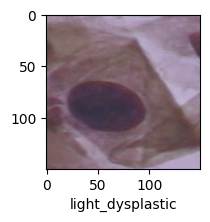

In [ ]:
plot_sample(X_test,y_test_new,5)

In [ ]:
classes[y_class[5]]

'light_dysplastic'

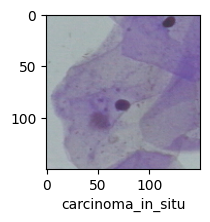

In [ ]:
plot_sample(X_train,y_test_new,1)

In [ ]:
classes[y_class[1]]

'severe_dysplastic'

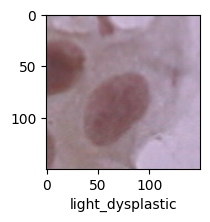

In [ ]:
plot_sample(X_train,y_test_new,0)

In [ ]:
classes[y_class[0]]

'light_dysplastic'

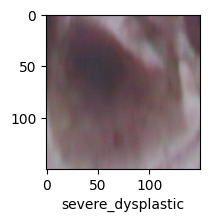

In [ ]:
plot_sample(X_train,y_test_new,11 )

In [ ]:
classes[y_class[11]]

'severe_dysplastic'

Shap

In [ ]:
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predicted_class

1/1 [==============================] - 2s 2s/step


array([6, 1, 1, 3, 4, 5, 6])

In [ ]:
print(classification_report(y_test_new,y_class))

              precision    recall  f1-score   support

           0       0.61      0.73      0.67        15
           1       0.80      0.84      0.82        19
           2       0.25      0.29      0.27         7
           3       0.85      0.79      0.81        14
           4       0.80      0.80      0.80         5
           5       0.86      0.86      0.86         7
           6       0.71      0.60      0.65        25

    accuracy                           0.71        92
   macro avg       0.70      0.70      0.70        92
weighted avg       0.72      0.71      0.71        92



In [ ]:
cm=tf.math.confusion_matrix(labels=y_test_new,predictions=y_class)
cm

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[11,  0,  0,  1,  0,  0,  3],
       [ 0, 16,  3,  0,  0,  0,  0],
       [ 0,  3,  2,  1,  0,  0,  1],
       [ 0,  1,  0, 11,  0,  0,  2],
       [ 0,  0,  0,  0,  4,  1,  0],
       [ 0,  0,  0,  0,  1,  6,  0],
       [ 7,  0,  3,  0,  0,  0, 15]], dtype=int32)>

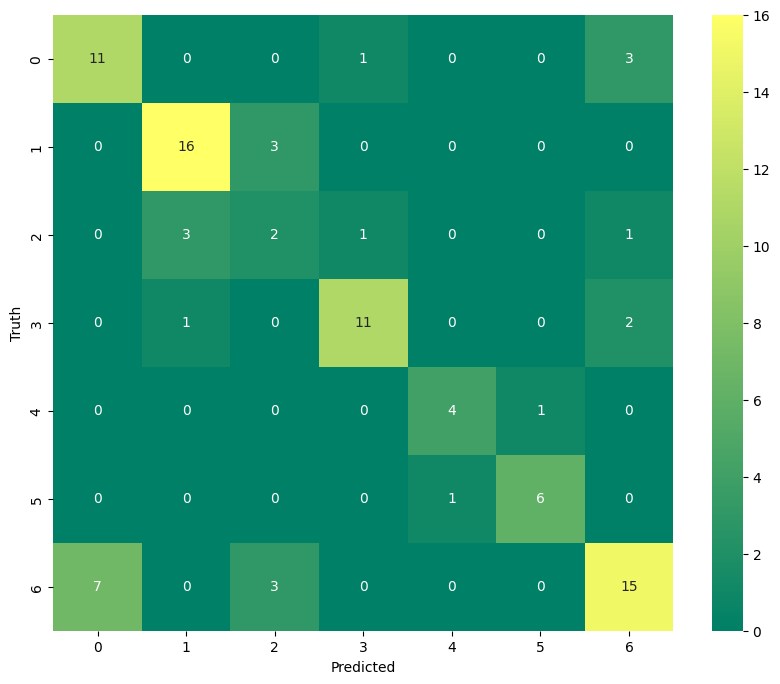

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='summer')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig(".png")


In [ ]:
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 7, figsize=(16, 15))
  axes = axes.flatten()

  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[int(k)]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (classes[k], classes[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()


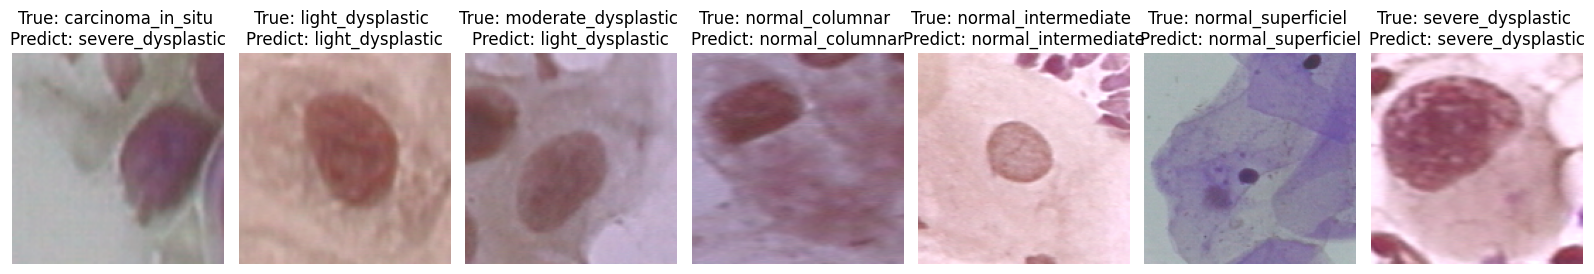

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_actual_predicted(images_dict, predicted_class)
plt.savefig('predited.png',dpi=300)


In [ ]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 12.0 MB/s eta 0:00:00


Shap

S

In [ ]:
masker = shap.maskers.Image("inpaint_telea", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=classes)

explainer

In [ ]:
shap_values = explainer(x_test_each_class, outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 1/7 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 3/7 [02:15<01:30, 22.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 4/7 [02:59<01:34, 31.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████▏  | 5/7 [03:46<01:15, 37.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 6/7 [04:31<00:39, 39.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 7/7 [05:17<00:00, 42.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 8it [06:01, 51.64s/it]


(7, 150, 150, 3, 5)

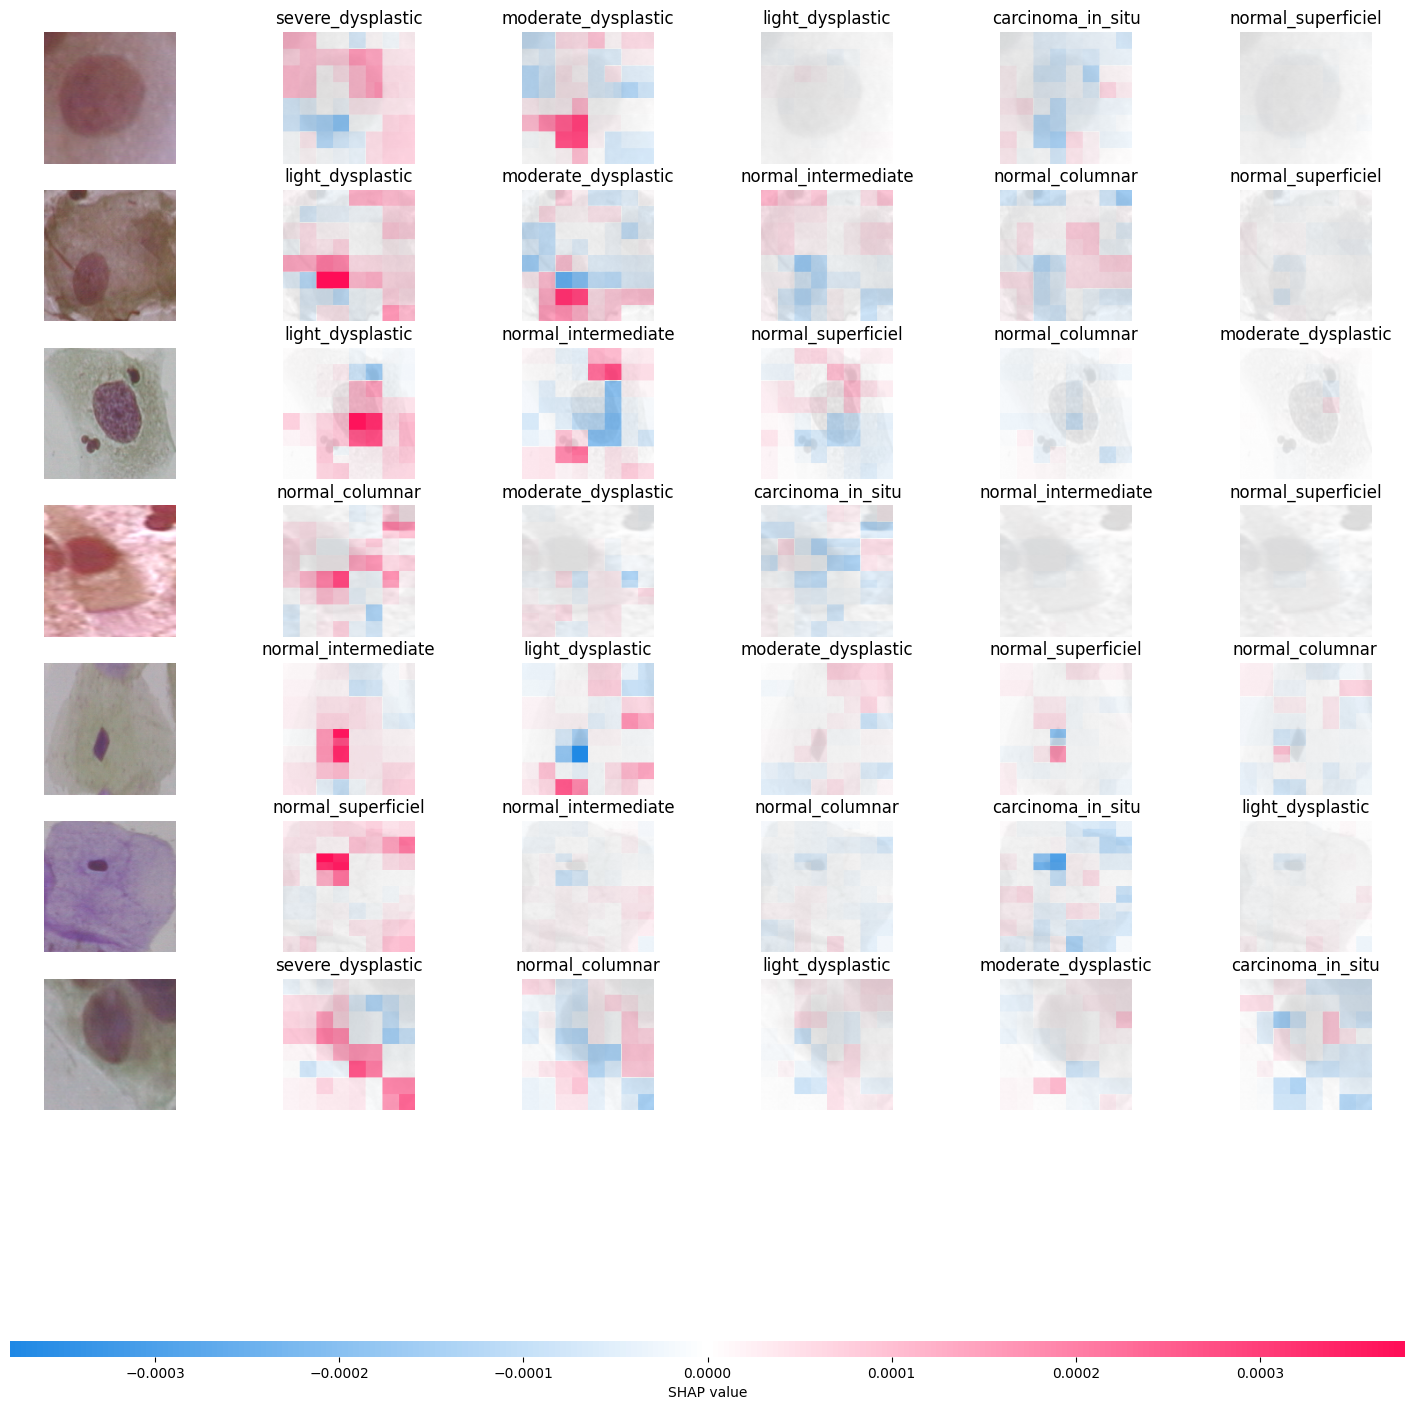

In [ ]:
shap.image_plot(shap_values)